In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np 
from numpy import exp
from scipy.optimize import curve_fit
import pandas as pd
from lmfit import Model, conf_interval, minimize, Minimizer, Parameter, Parameters, report_fit
import h5py
from scipy.signal import savgol_filter
from astropy import units as u
from plasmapy.diagnostics.langmuir import Characteristic, swept_probe_analysis, extract_exponential_section, get_electron_temperature, get_ion_density_LM, get_ion_saturation_current, get_electron_saturation_current, get_electron_density_LM


In [2]:
def ion_den(I_sat, T, M_i, A):
    kb = 1.38*(10**(-23)) #J/K
    q = 1.602*(10**(-19)) #Colombs
    sqrtterm = np.sqrt((kb*T) / M_i)
    result = I_sat / (A*0.61*sqrtterm*q)
    return result

def e_den(I_esat, T, A):
    me = 9.1*(10**(-31))#kg
    kb = 1.38*(10**(-23)) #J/K
    q = 1.602*(10**(-19)) #Colombs
    sqrtterm = np.sqrt((kb*T) / (2*np.pi*me))
    result = I_esat / (A*sqrtterm*q)
    return result


M_ar = 6.64*(10**(-26))
A = (2*(10**(-3)))**(2)
T = 23206
ion_sat = 100*(10**(-6))
print(ion_den(ion_sat, T, M_ar, A))

1.1649090371150421e+17


In [3]:
files_1ms = ['Langmuir_Data\linefx_RF300V_BGradConfig2_1mTorr_1V_tt1ms_tsweep300us_R10_port2_2-28-2025.hdf5', 'Langmuir_Data\linefx_RF300V_BGradConfig2_1mTorr_1V_tt1ms_tsweep300us_R10_2-14-2025.hdf5', 'Langmuir_Data\linefx_RF300V_BGradConfig2_1mTorr_1V_tt1ms_tsweep300us_R10_port4_2-27-2025.hdf5']
files_5ms = ['Langmuir_Data\linefx_RF300V_BGradConfig2_1mTorr_1V_tt5ms_tsweep1200us_R100_port2_2-28-2025.hdf5', 'Langmuir_Data\linefx_RF300V_BGradConfig2_1mTorr_1V_tt5ms_tsweep300us_R100_2-14-2025.hdf5', 'Langmuir_Data\linefx_RF300V_BGradConfig2_1mTorr_1V_tt5ms_tsweep1200us_R10_port4_2-27-2025.hdf5']

### Test cell for temperature data depending on the file

33


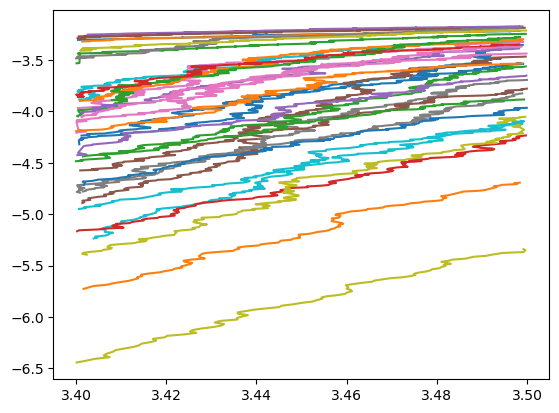

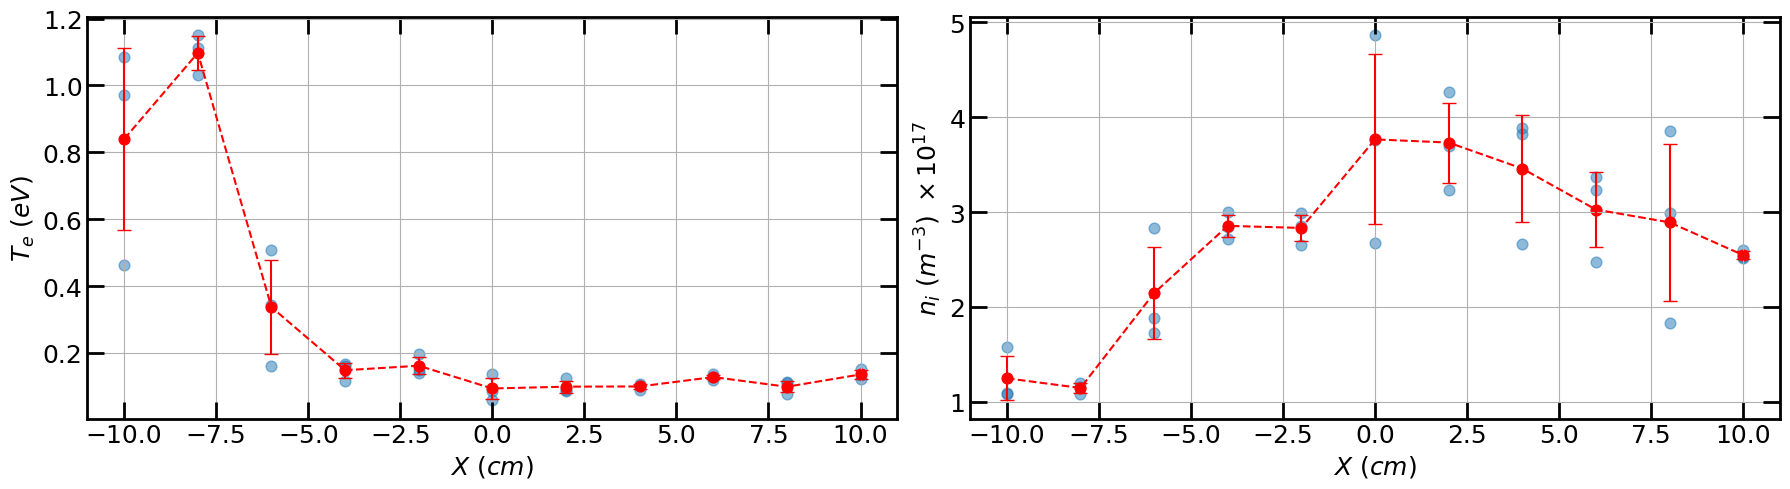

In [25]:
file_name = files_5ms[1]

#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]

print(len(positions))
shot_current = (dataset2[1])[8000:-60000]
shot_voltage = (dataset1[1])[8000:-60000]

#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []
n_e = []


#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)


#Loop through all positions and shots taken
for i in range(len(positions)):
    shot_current = (dataset2[i])[10000:-16000]
    shot_voltage = (dataset1[i])[10000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #print(swept_probe_analysis(plasma, probe_area, "Ar", visualize = True))

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)

    #See what all the smooth traces look like
    #plt.plot(smooth_voltage, smooth_current)


    smooth_current = smooth_current / 10
    #I_log = np.log(smooth_current)
    I_log = np.log(smooth_current[(smooth_voltage >= 3.4) & (smooth_voltage <= 3.5)])
    v = smooth_voltage[(smooth_voltage >= 3.4) & (smooth_voltage <= 3.5)]

    plt.plot(v, I_log)
    #plt.plot(smooth_voltage, I_log)
    #plt.plot(smooth_voltage, smooth_current)

    z, zcov = np.polyfit(v, I_log, 1, cov = True)
    z_err = np.sqrt(np.diagonal(zcov))
    T_kelvin = (1 / z[0])*(11604)
    T_eV = (1 / z[0]) * u.electronvolt


    T.append(1 / z[0])
    T_err.append(z_err[0])
    x.append(positions[i][1])
    I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= 0)])
    n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    #n_i.append(ion_den(np.abs(I_sat), 5803, M_ar, probe_area))
    V_f.append(np.interp(0, smooth_current, smooth_voltage))



T1 = np.array(T)
T_shaped_1 = T1.reshape(11, 3)
n_i_1 = np.array(n_i)
n_i_shaped_1 = n_i_1.reshape(11, 3)

x_reduced = np.linspace(-10, 10, 11)


T_shotavg_1 = np.mean(T_shaped_1, axis = 1)
n_i_shotavg_1 = np.mean(n_i_shaped_1, axis = 1)
T_err1 = np.std(T_shaped_1, axis = 1)
n_i_err1 = np.std(n_i_shaped_1, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)





#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T1, alpha = 0.5, s = 60)
ax[0].plot(x_reduced, T_shotavg_1, linestyle = 'dashed', color = 'red')
ax[0].scatter(x_reduced, T_shotavg_1, s = 60, color = 'red')
ax[0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0].errorbar(x_reduced, T_shotavg_1, yerr = T_err1, fmt = 'none', capsize = 5, color = 'red')
ax[0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i_1/(10**(17)), alpha = 0.5, s = 60)
ax[1].scatter(x_reduced, n_i_shotavg_1/(10**(17)), s = 60, color = 'red')
ax[1].plot(x_reduced, n_i_shotavg_1/(10**(17)), linestyle = 'dashed', color = 'red')
ax[1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1].errorbar(x_reduced, n_i_shotavg_1/(10**(17)), yerr = (n_i_err1/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1].grid()
plt.tight_layout()


### Analysis for Magnetic Mirror 1ms into afterglow for port 2

C:\Users\Demon\AppData\Local\Temp\ipykernel_21308\3602416428.py:42: RuntimeWarning: invalid value encountered in log
  I_log = np.log(smooth_current)


'\nfig, ax = plt.subplots(1, 2, figsize = (20, 7))\n#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################\nax[0].scatter(x, T)\n\nax[0].set_xlabel(\'X (cm)\', fontsize = 12)\nax[0].set_ylabel(\'Temperature (eV)\', fontsize = 12)\n\n#################### PLOT DENSITY AS A FUNCTION OF X ##########################\nax[1].scatter(x, n_i)\n\nax[1].set_xlabel(\'X (cm)\', fontsize = 12)\nax[1].set_ylabel(\'Ion Density (cm^-3)\', fontsize = 12)\n\nplt.suptitle("Port 2", fontsize = 15, y = 1.007)\n'

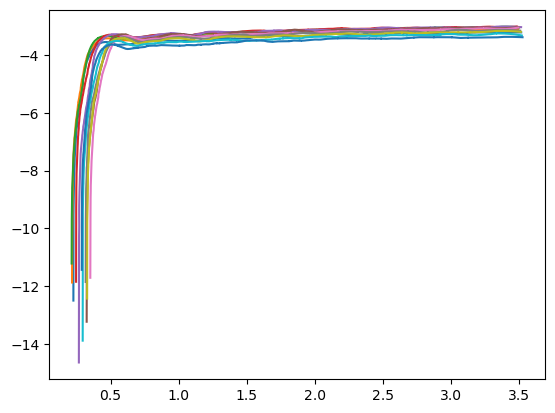

In [16]:
file_name = files_1ms[0] 

#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]


start = [0.25, 0.25, 0.25, 0.28, 0.29, 0.35, 0.37, 0.38, 0.38, 0.38, 0.38]
stop = [0.3, 0.3, 0.3, 0.31, 0.34, 0.4, 0.42, 0.45, 0.45, 0.43, 0.425]

#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []

#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)

#Loop through all positions and shots taken
for i in range(len(positions)):

    shot_current = (dataset2[i])[9000:-16000]
    shot_voltage = (dataset1[i])[9000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)
    smooth_current = smooth_current / 10

    I_log = np.log(smooth_current)
    #I_log = np.log(smooth_current[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])])
    v = smooth_voltage[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])]

    #I_log = np.log(smooth_current[(smooth_voltage >= 0.36) & (smooth_voltage <= 0.5)])
    #v = smooth_voltage[(smooth_voltage >= 0.36) & (smooth_voltage <= 0.5)]

    #See what all the smooth traces look like
    plt.plot(smooth_voltage, I_log)
    #plt.plot(v, I_log)
    #plt.plot(smooth_voltage, smooth_current)


    #z, zcov = np.polyfit(v, I_log, 1, cov = True)
    #z_err = np.sqrt(np.diagonal(zcov))
    #print(z)
    #T_kelvin = (1 / z[0])*(11604)
#
    #T.append(1 / z[0])
    #T_err.append(z_err[0])
    #x.append(positions[i][1])
    #I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= -1)])
    #n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    #V_f.append(np.interp(0, smooth_current, smooth_voltage))

'''
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T)

ax[0].set_xlabel('X (cm)', fontsize = 12)
ax[0].set_ylabel('Temperature (eV)', fontsize = 12)

#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i)

ax[1].set_xlabel('X (cm)', fontsize = 12)
ax[1].set_ylabel('Ion Density (cm^-3)', fontsize = 12)

plt.suptitle("Port 2", fontsize = 15, y = 1.007)
'''

### Analysis for Magnetic Mirror 1ms into afterglow for port 3

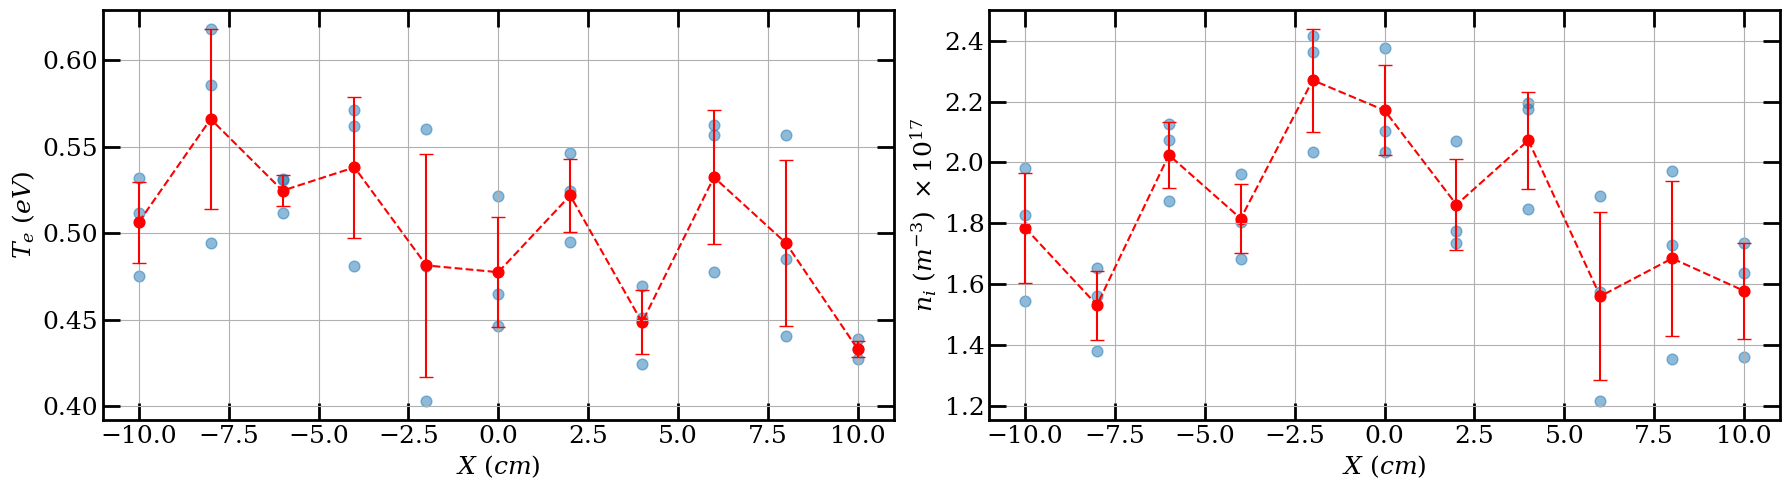

In [122]:
file_name = files_1ms[1] 


#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]




#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []
n_e = []


#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)


#Loop through all positions and shots taken
for i in range(len(positions)):
    shot_current = (dataset2[i])[9000:-16000]
    shot_voltage = (dataset1[i])[9000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #print(swept_probe_analysis(plasma, probe_area, "Ar", visualize = True))

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)

    #See what all the smooth traces look like
    #plt.plot(smooth_voltage, smooth_current)


    smooth_current = smooth_current / 10
    #I_log = np.log(smooth_current)
    I_log = np.log(smooth_current[(smooth_voltage >= 3.3) & (smooth_voltage <= 3.8)])
    v = smooth_voltage[(smooth_voltage >= 3.3) & (smooth_voltage <= 3.8)]

    #plt.plot(v, I_log)
    #plt.plot(smooth_voltage, I_log)
    #plt.plot(smooth_voltage, smooth_current)

    z, zcov = np.polyfit(v, I_log, 1, cov = True)
    z_err = np.sqrt(np.diagonal(zcov))
    T_kelvin = (1 / z[0])*(11604)
    T_eV = (1 / z[0]) * u.electronvolt


    T.append(1 / z[0])
    T_err.append(z_err[0])
    x.append(positions[i][1])
    I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= 0)])
    n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    #n_i.append(ion_den(np.abs(I_sat), 5803, M_ar, probe_area))
    V_f.append(np.interp(0, smooth_current, smooth_voltage))



T1 = np.array(T)
T_shaped_1 = T1.reshape(11, 3)
n_i_1 = np.array(n_i)
n_i_shaped_1 = n_i_1.reshape(11, 3)

x_reduced = np.linspace(-10, 10, 11)


T_shotavg_1 = np.mean(T_shaped_1, axis = 1)
n_i_shotavg_1 = np.mean(n_i_shaped_1, axis = 1)
T_err1 = np.std(T_shaped_1, axis = 1)
n_i_err1 = np.std(n_i_shaped_1, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)





#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T1, alpha = 0.5, s = 60)
ax[0].plot(x_reduced, T_shotavg_1, linestyle = 'dashed', color = 'red')
ax[0].scatter(x_reduced, T_shotavg_1, s = 60, color = 'red')
ax[0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0].errorbar(x_reduced, T_shotavg_1, yerr = T_err1, fmt = 'none', capsize = 5, color = 'red')
ax[0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i_1/(10**(17)), alpha = 0.5, s = 60)
ax[1].scatter(x_reduced, n_i_shotavg_1/(10**(17)), s = 60, color = 'red')
ax[1].plot(x_reduced, n_i_shotavg_1/(10**(17)), linestyle = 'dashed', color = 'red')
ax[1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1].errorbar(x_reduced, n_i_shotavg_1/(10**(17)), yerr = (n_i_err1/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1].grid()
plt.tight_layout()
plt.savefig('T&n_bgrad2_port3.pdf')

### Analysis for Magnetic Mirror 1ms into afterglow for port 4

C:\Users\Demon\AppData\Local\Temp\ipykernel_29812\2566751774.py:49: RuntimeWarning: invalid value encountered in log
  I_log = np.log(smooth_current)


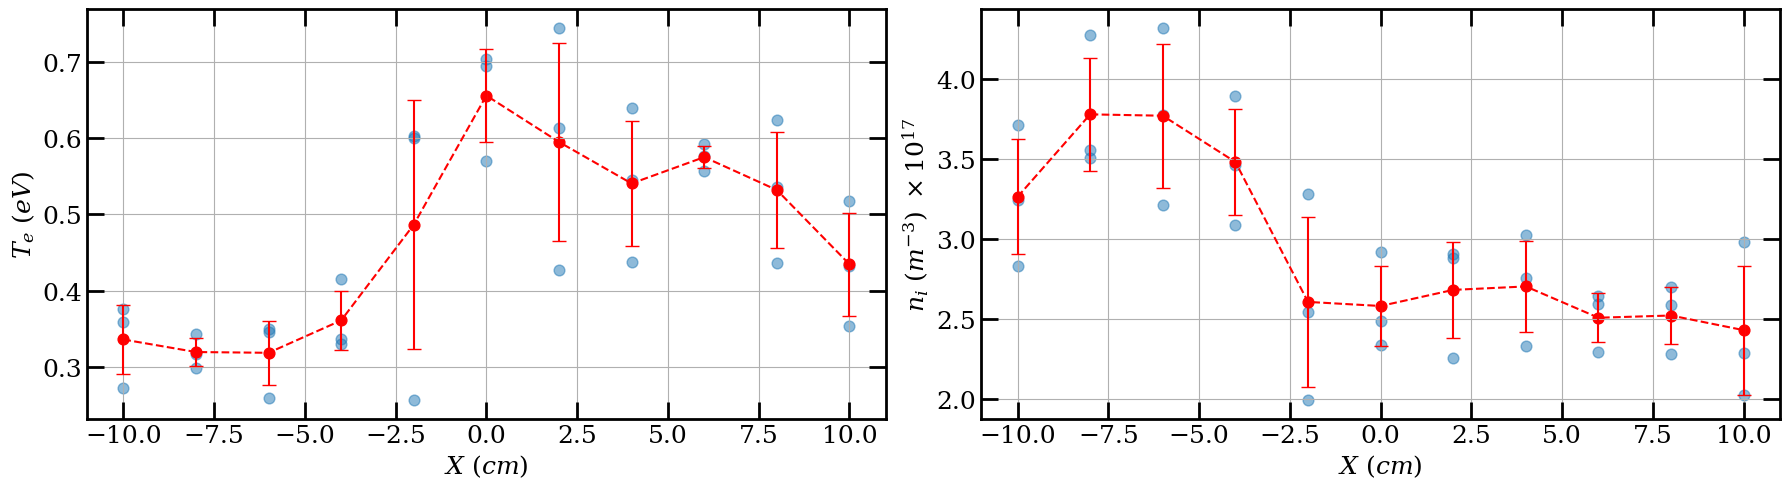

In [ ]:
file_name = files_1ms[2] 


#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]




#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []

#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)

start = [3.4, 3.4, 3.4, 3.5, 3.5, 3.5, 3.8, 3.8, 3.8, 4.3, 4.3, 4.3, 4.3, 5, 5, 5.4, 5.4, 5.4, 5.4, 5.4, 5.2, 5.4, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.4, 4.4, 4.4]
stop = [3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 4.4, 4.4, 4.1, 4.8, 4.8, 4.8, 4.8, 5.5, 5.5, 6, 6, 5.7, 6, 6, 5.6, 6, 5.3, 5.3, 5.3, 5.3, 5.3, 5.1, 5.1, 5.1, 4.7, 4.7, 4.7]


#Loop through all positions and shots taken
for i in range(len(positions)):
    shot_current = (dataset2[i])[15000:-16000]
    shot_voltage = (dataset1[i])[15000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)

    #See what all the smooth traces look like
    #plt.plot(smooth_voltage, smooth_current)


    smooth_current = smooth_current / 10
    I_log = np.log(smooth_current)


    I_log = np.log(smooth_current[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])])
    v = smooth_voltage[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])]

    #I_log = np.log(smooth_current[(smooth_voltage >= 4.4) & (smooth_voltage <= 6)])
    #v = smooth_voltage[(smooth_voltage >= 4.4) & (smooth_voltage <= 6)]

    #plt.plot(v, I_log)
    #plt.plot(smooth_voltage, I_log)
    #plt.plot(smooth_voltage, smooth_current)




    z, zcov = np.polyfit(v, I_log, 1, cov = True)
    z_err = np.sqrt(np.diagonal(zcov))
    T_kelvin = (1 / z[0])*(11604)

    T.append(1 / z[0])
    T_err.append(z_err[0])
    x.append(positions[i][1])
    I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= 0)])
    n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    #n_i.append(ion_den(np.abs(I_sat), 5803, M_ar, probe_area))
    V_f.append(np.interp(0, smooth_current, smooth_voltage))



T = np.array(T)
T_shaped = T.reshape(11, 3)
n_i = np.array(n_i)
n_i_shaped = n_i.reshape(11, 3)

x_reduced = np.linspace(-10, 10, 11)


T_shotavg = np.mean(T_shaped, axis = 1)
n_i_shotavg = np.mean(n_i_shaped, axis = 1)
T_err = np.std(T_shaped, axis = 1)
n_i_err = np.std(n_i_shaped, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)





#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T, alpha = 0.5, s = 60)
ax[0].plot(x_reduced, T_shotavg, linestyle = 'dashed', color = 'red')
ax[0].scatter(x_reduced, T_shotavg, s = 60, color = 'red')
ax[0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0].errorbar(x_reduced, T_shotavg, yerr = T_err, fmt = 'none', capsize = 5, color = 'red')
ax[0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i/(10**(17)), alpha = 0.5, s = 60)
ax[1].scatter(x_reduced, n_i_shotavg/(10**(17)), s = 60, color = 'red')
ax[1].plot(x_reduced, n_i_shotavg/(10**(17)), linestyle = 'dashed', color = 'red')
ax[1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1].errorbar(x_reduced, n_i_shotavg/(10**(17)), yerr = (n_i_err/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1].grid()
plt.tight_layout()
plt.savefig('T&n_bgrad2_port4.pdf')

### Step Function port 3

In [4]:
grad3_files_1ms = ['Langmuir_Data\linefx_RF300V_BGradConfig3_1mTorr_1V_tt1ms_tsweep300us_R10_2-14-2025.hdf5', 'Langmuir_Data\linefx_RF300V_BGradConfig3_1mTorr_1V_tt1ms_tsweep300us_R10_port4_2-27-2025.hdf5']

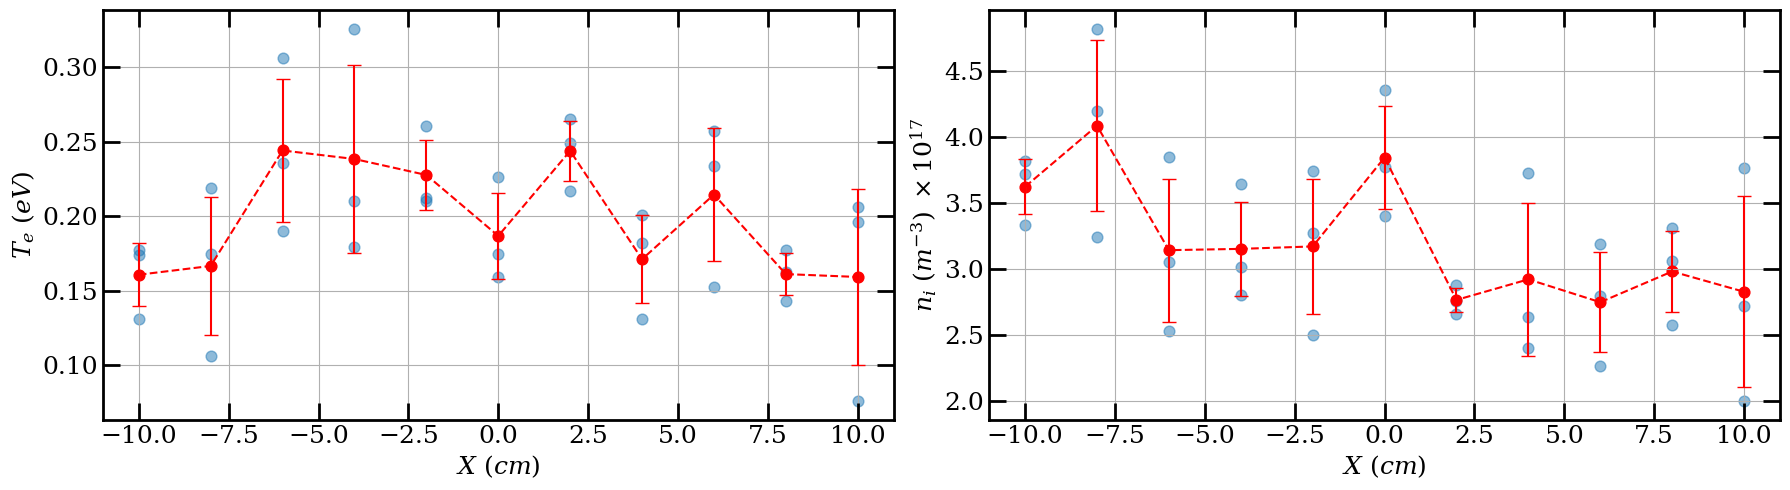

In [123]:
file_name = grad3_files_1ms[0] 


#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]




#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []

#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)


start = [8.5, 8.5, 8.6, 8.3, 8.4, 8.4, 8.4, 8.4, 8.5, 8.4, 8.4, 8.4, 8.5, 8.6, 8.6, 8.6, 8.7, 8.5, 8.7, 8.7, 8.7, 8.75, 8.75, 8.75, 8.9, 8.9, 9.0, 9.1, 9.0, 9.0, 9.15, 9.1, 9.3]
stop = [8.9, 8.9, 8.8, 8.45, 8.7, 8.8, 8.8, 8.8, 8.75, 8.8, 8.8, 8.8, 8.8, 8.8, 8.8, 8.8, 8.85, 8.8, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 9.2, 9.2, 9.2, 9.2, 9.2, 9.2, 9.25, 9.3, 9.4]

#Loop through all positions and shots taken
for i in range(len(positions)):
    shot_current = (dataset2[i])[15000:-16000]
    shot_voltage = (dataset1[i])[15000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)

    #See what all the smooth traces look like
    #plt.plot(smooth_voltage, smooth_current)

    smooth_current = smooth_current / 10
    #I_log = np.log(smooth_current)

    #plt.plot(smooth_voltage, I_log)

    I_log = np.log(smooth_current[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])])
    v = smooth_voltage[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])]

    #I_log = np.log(smooth_current[(smooth_voltage >= 4.4) & (smooth_voltage <= 9.5)])
    #v = smooth_voltage[(smooth_voltage >= 4.4) & (smooth_voltage <= 9.5)]

    #plt.plot(v, I_log)

    #plt.plot(smooth_voltage, smooth_current)




    z, zcov = np.polyfit(v, I_log, 1, cov = True)
    z_err = np.sqrt(np.diagonal(zcov))
    T_kelvin = (1 / z[0])*(11604)

    T.append(1 / z[0])
    T_err.append(z_err[0])
    x.append(positions[i][1])
    I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= 0)])
    n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    V_f.append(np.interp(0, smooth_current, smooth_voltage))



T2 = np.array(T)
T_shaped_2= T2.reshape(11, 3)
n_i_2 = np.array(n_i)
n_i_shaped_2 = n_i_2.reshape(11, 3)

x_reduced = np.linspace(-10, 10, 11)


T_shotavg_2 = np.mean(T_shaped_2, axis = 1)
n_i_shotavg_2 = np.mean(n_i_shaped_2, axis = 1)
T_err2 = np.std(T_shaped_2, axis = 1)
n_i_err2 = np.std(n_i_shaped_2, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)





#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T2, alpha = 0.5, s = 60)
ax[0].plot(x_reduced, T_shotavg_2, linestyle = 'dashed', color = 'red')
ax[0].scatter(x_reduced, T_shotavg_2, s = 60, color = 'red')
ax[0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0].errorbar(x_reduced, T_shotavg_2, yerr = T_err2, fmt = 'none', capsize = 5, color = 'red')
ax[0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i_2/(10**(17)), alpha = 0.5, s = 60)
ax[1].scatter(x_reduced, n_i_shotavg_2/(10**(17)), s = 60, color = 'red')
ax[1].plot(x_reduced, n_i_shotavg_2/(10**(17)), linestyle = 'dashed', color = 'red')
ax[1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1].errorbar(x_reduced, n_i_shotavg_2/(10**(17)), yerr = (n_i_err2/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1].grid()
plt.tight_layout()
plt.savefig('T&n_bgrad3_port3.pdf')


### Step Function port 4

C:\Users\Demon\AppData\Local\Temp\ipykernel_29812\167046759.py:48: RuntimeWarning: invalid value encountered in log
  I_log = np.log(smooth_current)


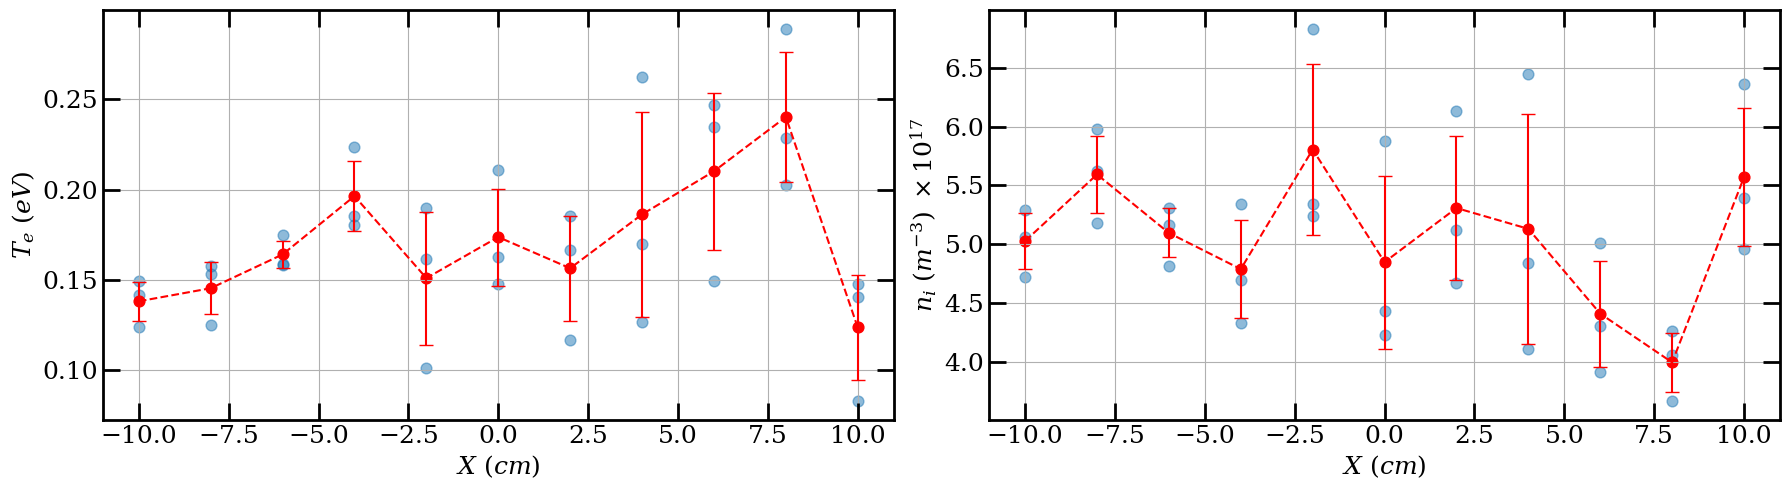

In [125]:
file_name = grad3_files_1ms[1] 


#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]




#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []

#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)


start = [7.5, 7.8, 7.5, 7.6, 7.4, 7.6, 7.6, 7.8, 7.7, 7.7, 7.7, 7.7, 7.8, 7.8, 7.8, 7.8, 7.8, 7.8, 8.0, 7.9, 8.1, 8.1, 8.0, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1]
stop = [7.8, 8.0, 7.8, 8.0, 7.7, 8.0, 8.0, 8.0, 8.0, 8.1, 8.0, 8.0, 8.1, 8.1, 8.0, 8.0, 8.0, 8.0, 8.3, 8.1, 8.3, 8.3, 8.3, 8.4, 8.5, 8.5, 8.4, 8.5, 8.4, 8.4, 8.4, 8.3, 8.3]

#Loop through all positions and shots taken
for i in range(len(positions)):
    shot_voltage = (dataset1[i])[15000:-16000]
    shot_current = (dataset2[i])[15000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)

    #See what all the smooth traces look like
    #plt.plot(smooth_voltage, smooth_current)

    smooth_current = smooth_current / 10
    I_log = np.log(smooth_current)

    #plt.plot(smooth_voltage, I_log)

    I_log = np.log(smooth_current[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])])
    v = smooth_voltage[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])]

    #I_log = np.log(smooth_current[(smooth_voltage >= 7) & (smooth_voltage <= 9)])
    #v = smooth_voltage[(smooth_voltage >= 7) & (smooth_voltage <= 9)]

    #plt.plot(v, I_log, linestyle = 'dashed')

    #plt.plot(smooth_voltage, smooth_current)




    z, zcov = np.polyfit(v, I_log, 1, cov = True)
    z_err = np.sqrt(np.diagonal(zcov))
    T_kelvin = (1 / z[0])*(11604)

    T.append(1 / z[0])
    T_err.append(z_err[0])
    x.append(positions[i][1])
    I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= 0)])
    n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    V_f.append(np.interp(0, smooth_current, smooth_voltage))



T3 = np.array(T)
T_shaped_3 = T3.reshape(11, 3)
n_i_3 = np.array(n_i)
n_i_shaped_3 = n_i_3.reshape(11, 3)

x_reduced = np.linspace(-10, 10, 11)


T_shotavg_3 = np.mean(T_shaped_3, axis = 1)
n_i_shotavg_3 = np.mean(n_i_shaped_3, axis = 1)
T_err3 = np.std(T_shaped_3, axis = 1)
n_i_err3 = np.std(n_i_shaped_3, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)





#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T3, alpha = 0.5, s = 60)
ax[0].plot(x_reduced, T_shotavg_3, linestyle = 'dashed', color = 'red')
ax[0].scatter(x_reduced, T_shotavg_3, s = 60, color = 'red')
ax[0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0].errorbar(x_reduced, T_shotavg_3, yerr = T_err3, fmt = 'none', capsize = 5, color = 'red')
ax[0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i_3/(10**(17)), alpha = 0.5, s = 60)
ax[1].scatter(x_reduced, n_i_shotavg_3/(10**(17)), s = 60, color = 'red')
ax[1].plot(x_reduced, n_i_shotavg_3/(10**(17)), linestyle = 'dashed', color = 'red')
ax[1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1].errorbar(x_reduced, n_i_shotavg_3/(10**(17)), yerr = (n_i_err3/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1].grid()
plt.tight_layout()
plt.savefig('T&n_bgrad3_port4.pdf')

### Make Big Plot

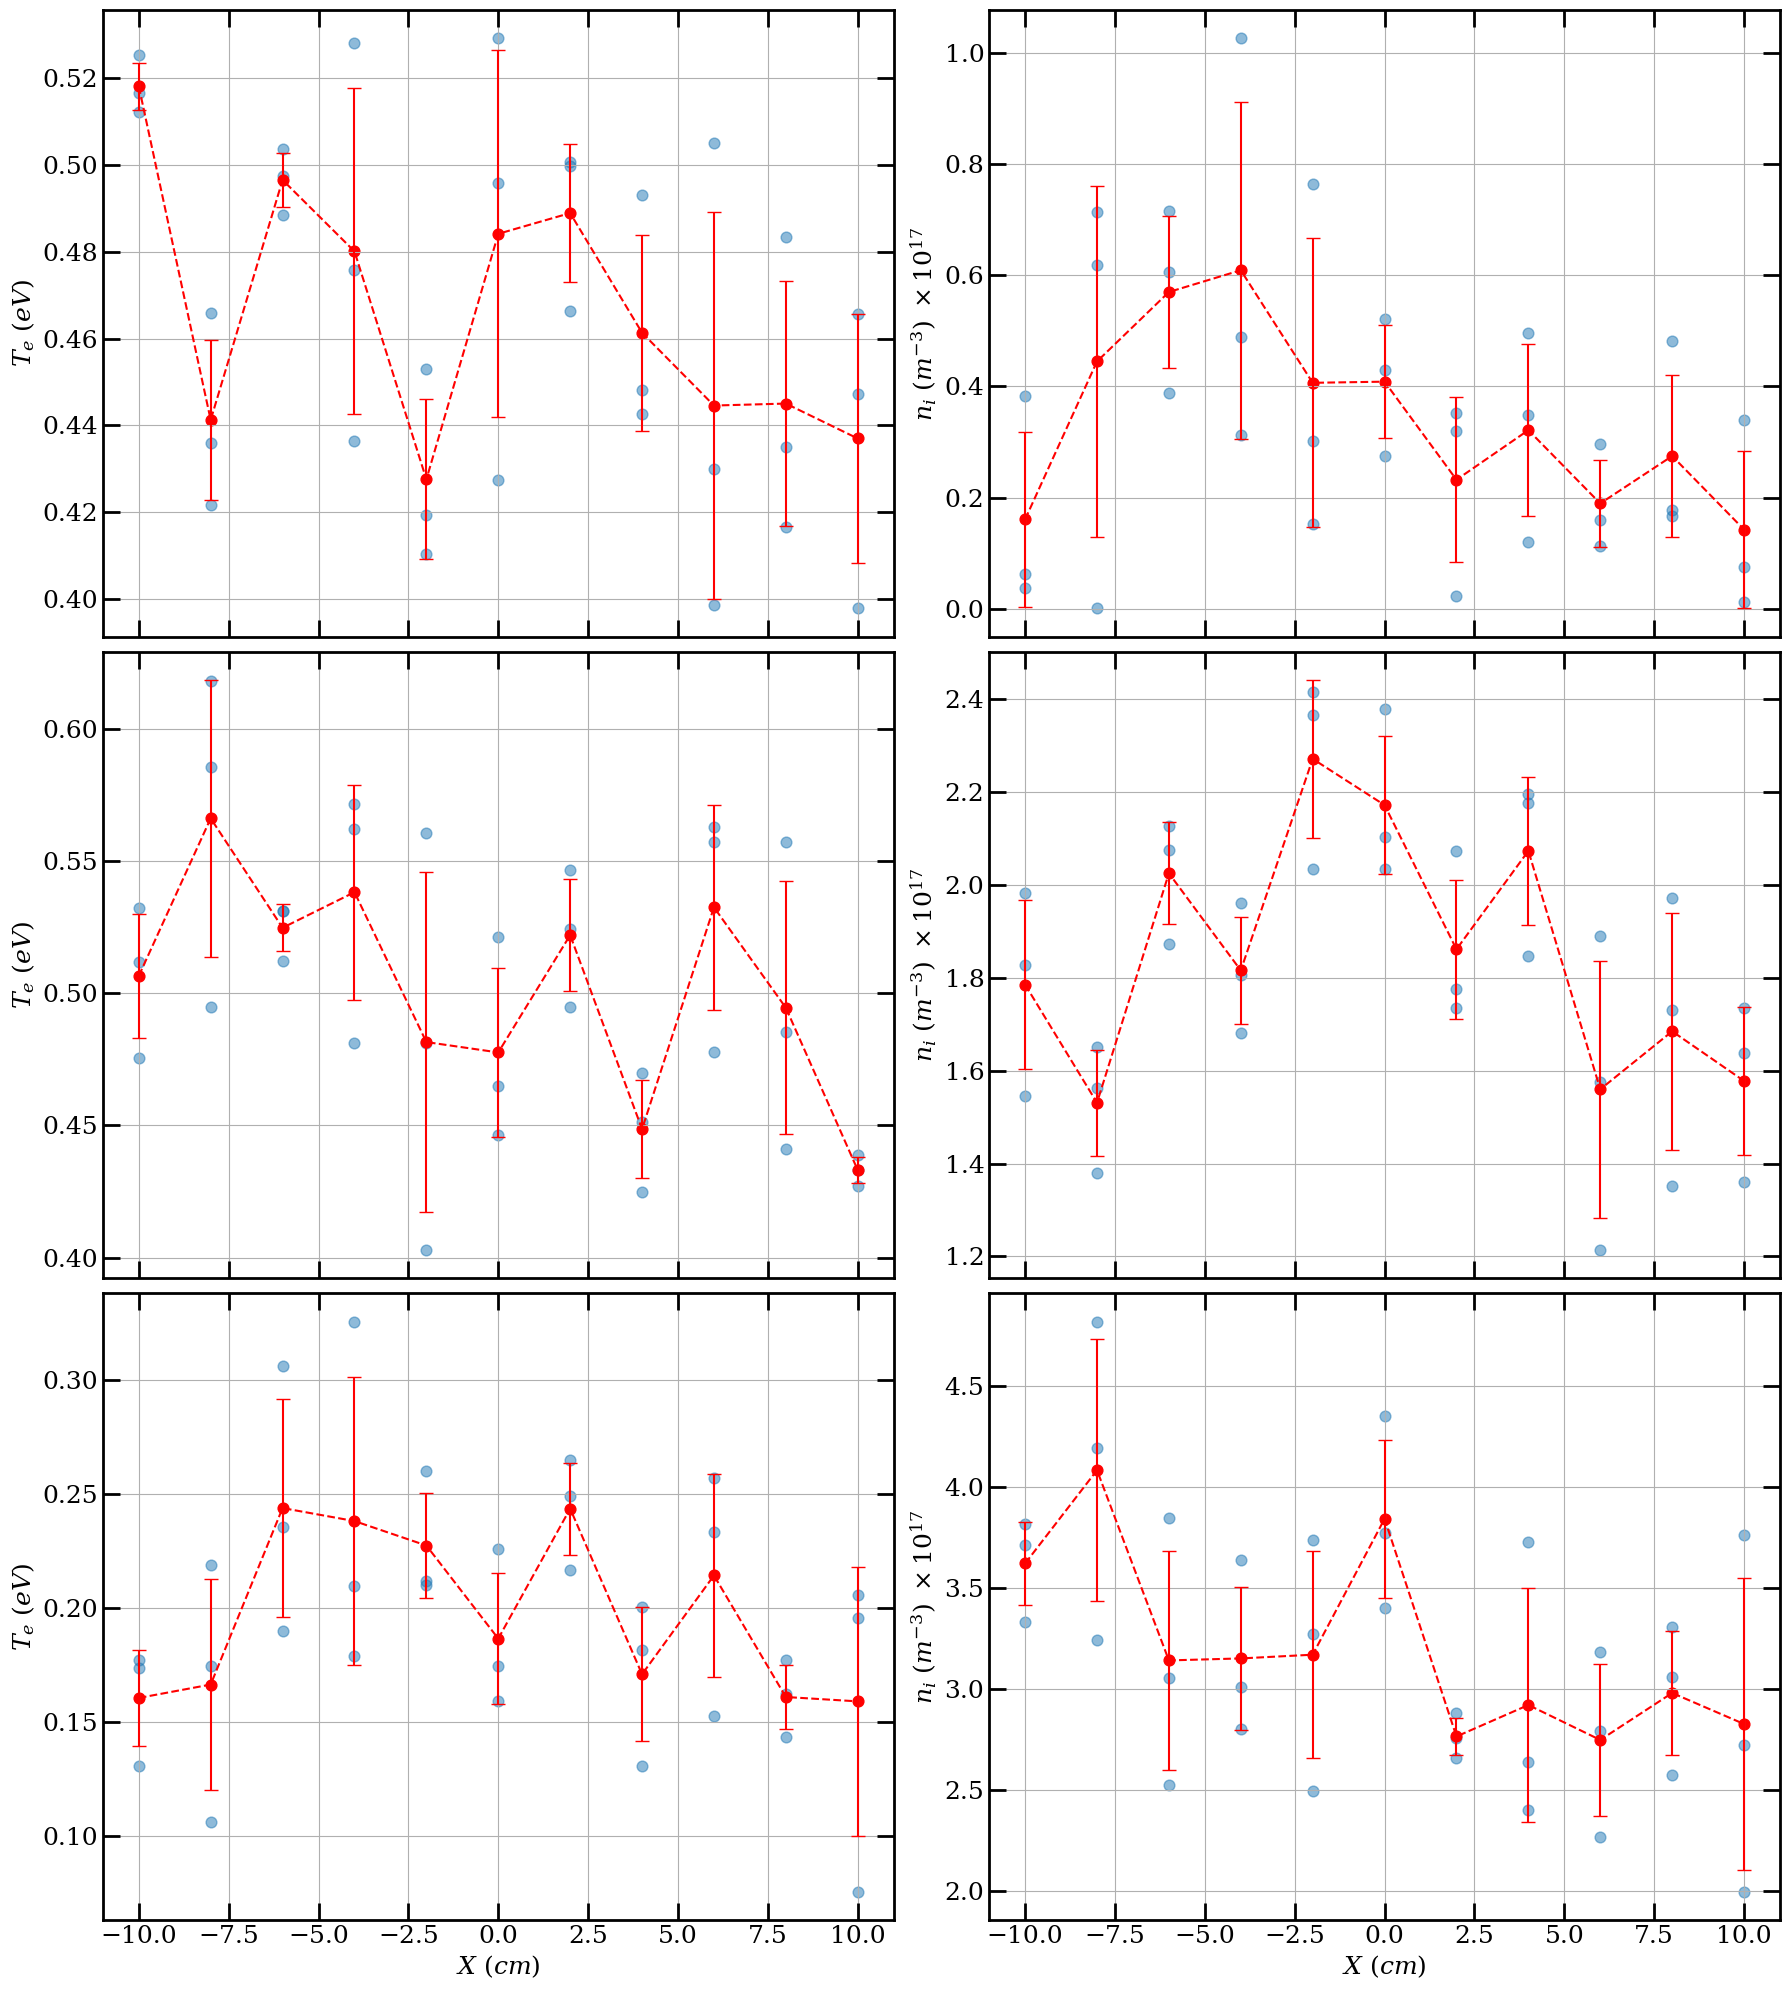

In [143]:
fig, ax = plt.subplots(3, 2, sharex = True, figsize = (18, 20))

plt.setp(ax[0][0].spines.values(), linewidth=2)
plt.setp(ax[0][1].spines.values(), linewidth=2)
plt.setp(ax[1][0].spines.values(), linewidth=2)
plt.setp(ax[1][1].spines.values(), linewidth=2)
plt.setp(ax[2][0].spines.values(), linewidth=2)
plt.setp(ax[2][1].spines.values(), linewidth=2)

ax[0][0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0][0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1][0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1][0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[2][0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[2][0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)

ax[0][1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0][1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1][1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1][1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[2][1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[2][1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[1][0].scatter(x, T1, alpha = 0.5, s = 60)
ax[1][0].plot(x_reduced, T_shotavg_1, linestyle = 'dashed', color = 'red')
ax[1][0].scatter(x_reduced, T_shotavg_1, s = 60, color = 'red')
#ax[1][0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1][0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[1][0].errorbar(x_reduced, T_shotavg_1, yerr = T_err1, fmt = 'none', capsize = 5, color = 'red')
ax[1][0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1][1].scatter(x, n_i_1/(10**(17)), alpha = 0.5, s = 60)
ax[1][1].scatter(x_reduced, n_i_shotavg_1/(10**(17)), s = 60, color = 'red')
ax[1][1].plot(x_reduced, n_i_shotavg_1/(10**(17)), linestyle = 'dashed', color = 'red')
#ax[1][1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1][1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1][1].errorbar(x_reduced, n_i_shotavg_1/(10**(17)), yerr = (n_i_err1/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1][1].grid()


#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[2][0].scatter(x, T2, alpha = 0.5, s = 60)
ax[2][0].plot(x_reduced, T_shotavg_2, linestyle = 'dashed', color = 'red')
ax[2][0].scatter(x_reduced, T_shotavg_2, s = 60, color = 'red')
ax[2][0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[2][0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[2][0].errorbar(x_reduced, T_shotavg_2, yerr = T_err2, fmt = 'none', capsize = 5, color = 'red')
ax[2][0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[2][1].scatter(x, n_i_2/(10**(17)), alpha = 0.5, s = 60)
ax[2][1].scatter(x_reduced, n_i_shotavg_2/(10**(17)), s = 60, color = 'red')
ax[2][1].plot(x_reduced, n_i_shotavg_2/(10**(17)), linestyle = 'dashed', color = 'red')
ax[2][1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[2][1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[2][1].errorbar(x_reduced, n_i_shotavg_2/(10**(17)), yerr = (n_i_err2/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[2][1].grid()


#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0][0].scatter(x, T3, alpha = 0.5, s = 60)
ax[0][0].plot(x_reduced, T_shotavg_3, linestyle = 'dashed', color = 'red')
ax[0][0].scatter(x_reduced, T_shotavg_3, s = 60, color = 'red')
#ax[0][0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0][0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0][0].errorbar(x_reduced, T_shotavg_3, yerr = T_err3, fmt = 'none', capsize = 5, color = 'red')
ax[0][0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[0][1].scatter(x, n_i_3/(10**(17)), alpha = 0.5, s = 60)
ax[0][1].scatter(x_reduced, n_i_shotavg_3/(10**(17)), s = 60, color = 'red')
ax[0][1].plot(x_reduced, n_i_shotavg_3/(10**(17)), linestyle = 'dashed', color = 'red')
#ax[0][1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0][1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[0][1].errorbar(x_reduced, n_i_shotavg_3/(10**(17)), yerr = (n_i_err3/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[0][1].grid()


plt.tight_layout()
plt.savefig('T&n_all.pdf')

In [87]:
constb_files_1ms = ['Langmuir_Data\linefx_RF300V_70Guniform_1mTorr_1V_tt1000us_tsweep300us_R10_2-13-2025.hdf5']

### Constant 70G Field

C:\Users\Demon\AppData\Local\Temp\ipykernel_29812\550152320.py:48: RuntimeWarning: invalid value encountered in log
  I_log = np.log(smooth_current)


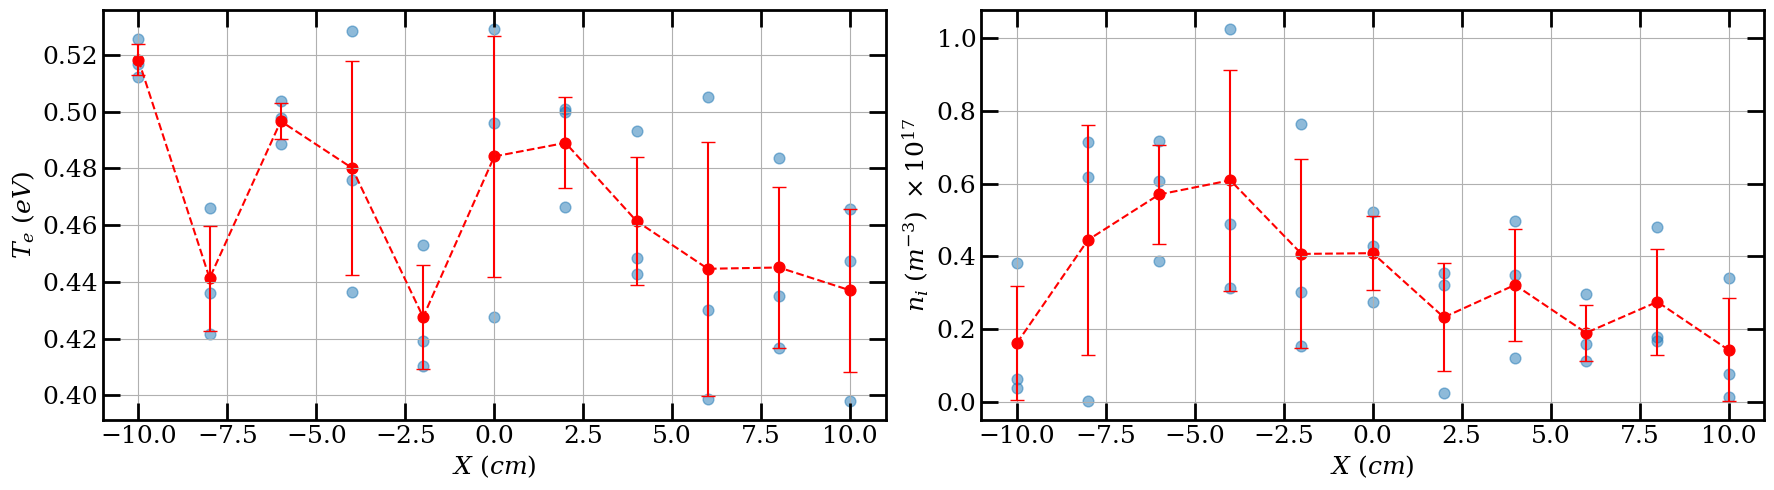

In [135]:
file_name = constb_files_1ms[0] 


#Read in the particular file and setup voltage and current 
file = h5py.File(file_name, 'r') 
dataset1 = file["/Acquisition/LeCroy_scope/Channel1"]
dataset2 = file["/Acquisition/LeCroy_scope/Channel2"]

positions = file["/Control/Positions/positions_setup_array"]




#Create arrays to add temperature and position values
T = []
T_err = []
x = []
n_i = []
V_f = []

#Assign variables to calculate stuff
M_ar = 6.64*(10**(-26))
probe_radius = 0.5*(10**(-2))
probe_area = np.pi * (probe_radius**2)


start = [7.5, 7.8, 7.5, 7.6, 7.4, 7.6, 7.6, 7.8, 7.7, 7.7, 7.7, 7.7, 7.8, 7.8, 7.8, 7.8, 7.8, 7.8, 8.0, 7.9, 8.1, 8.1, 8.0, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1, 8.1]
stop = [7.8, 8.0, 7.8, 8.0, 7.7, 8.0, 8.0, 8.0, 8.0, 8.1, 8.0, 8.0, 8.1, 8.1, 8.0, 8.0, 8.0, 8.0, 8.3, 8.1, 8.3, 8.3, 8.3, 8.4, 8.5, 8.5, 8.4, 8.5, 8.4, 8.4, 8.4, 8.3, 8.3]

#Loop through all positions and shots taken
for i in range(len(positions)):
    shot_voltage = (dataset1[i])[15000:-16000]
    shot_current = (dataset2[i])[15000:-16000]

    #Window and polynomial for smoothing
    win = 1000
    p = 2

    #Create smooth arrays of voltage and current
    smooth_voltage = savgol_filter(shot_voltage, win, p) #Volts
    smooth_current = savgol_filter(shot_current, win, p) #This is I*R (units of volts)
    np.array(smooth_current)

    #See what all the smooth traces look like
    #plt.plot(smooth_voltage, smooth_current)

    smooth_current = smooth_current / 10
    I_log = np.log(smooth_current)

    #plt.plot(smooth_voltage, I_log)

    #I_log = np.log(smooth_current[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])])
    #v = smooth_voltage[(smooth_voltage >= start[i]) & (smooth_voltage <= stop[i])]

    I_log = np.log(smooth_current[(smooth_voltage >= 0.2) & (smooth_voltage <= 1)])
    v = smooth_voltage[(smooth_voltage >= 0.2) & (smooth_voltage <= 1)]

    #plt.plot(v, I_log, linestyle = 'dashed')

    #plt.plot(smooth_voltage, smooth_current)




    z, zcov = np.polyfit(v, I_log, 1, cov = True)
    z_err = np.sqrt(np.diagonal(zcov))
    T_kelvin = (1 / z[0])*(11604)

    T.append(1 / z[0])
    T_err.append(z_err[0])
    x.append(positions[i][1])
    I_sat = np.mean(smooth_current[(smooth_voltage >= -10) & (smooth_voltage <= 0)])
    n_i.append(ion_den(np.abs(I_sat), T_kelvin, M_ar, probe_area))
    V_f.append(np.interp(0, smooth_current, smooth_voltage))



T3 = np.array(T)
T_shaped_3 = T3.reshape(11, 3)
n_i_3 = np.array(n_i)
n_i_shaped_3 = n_i_3.reshape(11, 3)

x_reduced = np.linspace(-10, 10, 11)


T_shotavg_3 = np.mean(T_shaped_3, axis = 1)
n_i_shotavg_3 = np.mean(n_i_shaped_3, axis = 1)
T_err3 = np.std(T_shaped_3, axis = 1)
n_i_err3 = np.std(n_i_shaped_3, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (18, 5))

plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 18)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 18)





#################### PLOT TEMPERATURE AS A FUNCTION OF X ##########################
ax[0].scatter(x, T3, alpha = 0.5, s = 60)
ax[0].plot(x_reduced, T_shotavg_3, linestyle = 'dashed', color = 'red')
ax[0].scatter(x_reduced, T_shotavg_3, s = 60, color = 'red')
ax[0].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[0].set_ylabel(r'$T_e~(eV)$', fontsize = 18)
ax[0].errorbar(x_reduced, T_shotavg_3, yerr = T_err3, fmt = 'none', capsize = 5, color = 'red')
ax[0].grid()
#################### PLOT DENSITY AS A FUNCTION OF X ##########################
ax[1].scatter(x, n_i_3/(10**(17)), alpha = 0.5, s = 60)
ax[1].scatter(x_reduced, n_i_shotavg_3/(10**(17)), s = 60, color = 'red')
ax[1].plot(x_reduced, n_i_shotavg_3/(10**(17)), linestyle = 'dashed', color = 'red')
ax[1].set_xlabel(r'$X~(cm)$', fontsize = 18)
ax[1].set_ylabel(r'$n_i~(m^{-3})~\times 10^{17}$', fontsize = 18)
ax[1].errorbar(x_reduced, n_i_shotavg_3/(10**(17)), yerr = (n_i_err3/(10**(17))), fmt = 'none', capsize = 5, color = 'red')
ax[1].grid()
plt.tight_layout()
plt.savefig('T&n_const_port3.pdf')